This jupyter notebook compares the solutions obtained with finite differences and moltres for a 1D and pseudo 1D cases.

In [2]:
import numpy as np
import numpy.linalg as la
from scipy.sparse import diags
import matplotlib.pyplot as plt
import yt

def plotter(file, p1, p2):
    field_label = {('all', 'group1'): r'$\phi_1\ moltres$',
                   ('all', 'group2'): r'$\phi_2\ moltres$'}

    ds = yt.load(file+'.e', step=-1)

    plt = yt.LinePlot(ds, [('all', 'group1'), ('all', 'group2')],
                      [p1[0], p1[1], 0], [p2[0], p2[1], 0],
                      1000, field_labels=field_label)

    plt.annotate_legend(('all', 'group1'))
    plt.set_x_unit('cm')
    plt.set_xlabel('z (cm)')
    # plt.set_ylabel(r'Fluxes ($\mathrm{10^{13}cm^{-2} s^{-1}}$)')
    plt.set_ylabel('Fluxes')
    plt._setup_plots()
    #plt.save(home+'/projects/moltres/problems/mhtgr350/'+file+'.png')
    plt.show()

def get_xs(base):
    inFile = base + 'DIFFCOEF.txt'
    with open(inFile, 'r') as i:
        data = i.readlines()
    lines = list()
    for line in data:
        lines.append(line.split())
    D = float(lines[0][1]), float(lines[0][2])

    inFile = base + 'REMXS.txt'
    with open(inFile, 'r') as i:
        data = i.readlines()
    lines = list()
    for line in data:
        lines.append(line.split())
    sr = float(lines[0][1]), float(lines[0][2])

    inFile = base + 'SP0.txt'
    with open(inFile, 'r') as i:
        data = i.readlines()
    lines = list()
    for line in data:
        lines.append(line.split())
    # sigmaS21, sigmaS12
    ss = float(lines[0][3]), float(lines[0][2])

    inFile = base + 'CHIT.txt'
    with open(inFile, 'r') as i:
        data = i.readlines()
    lines = list()
    for line in data:
        lines.append(line.split())
    chi = float(lines[0][1]), float(lines[0][2])

    inFile = base + 'NSF.txt'
    with open(inFile, 'r') as i:
        data = i.readlines()
    lines = list()
    for line in data:
        lines.append(line.split())
    nusf = float(lines[0][1]), float(lines[0][2])
    
    return D, sr, ss, chi, nusf

# 2 Groups, 1 Region

* Equations and assumptions:

$\chi_1 = 1, \chi_2 = 0, \Sigma^s_{21} = 0$

$0 = D_1 \frac{d^2}{dx^2}\Phi_1 - \Sigma^r_1 \Phi_1 + \nu\Sigma^f_1 \Phi_1 + \nu\Sigma^f_2 \Phi_2$

$0 = D_2 \frac{d^2}{dx^2}\Phi_2 - \Sigma^r_2 \Phi_2 + \Sigma^s_{12} \Phi_1$

* BCs:

1) $\Phi_1(0) = 0$

2) $\Phi_2(0) = 0$

3) $\Phi_1(a) = 0$

4) $\Phi_2(a) = 0$

* Matrix form, eigenvalues, and eigenvectors:

$D = \left(\begin{matrix} D_1 & 0 \\ 0 & D_2 \end{matrix}\right)$

$E_{\infty} = \left(\begin{matrix} \nu\Sigma^f_1/k-\Sigma^r_1 & \nu\Sigma^f_2/k \\ \Sigma^s_{12} & -\Sigma^r_2 \end{matrix}\right)$

$\bar{0} = D \frac{d^2}{dx^2} \bar{\Phi}+ E_{\infty} \bar{\Phi}$

$\beta^2, -\mu^2 = eigenvalues of D^{-1}E_{\infty}$

$eigenvectors of D^{-1}E_{\infty} = \left(\begin{matrix} 1 & 1 \\ S_1 & S_2 \end{matrix}\right)$

We still don't know $\beta$, $\mu$, $S_1$, or $S_2$, we need $k$ first.

* Flux shape:

$\Phi_1(x) = A sin(\beta x) + B cos(\beta x) + C sinh(\mu x) + D cosh(\mu x)$
$\Phi_2(x) = S_1 A sin(\beta x) + S_1 B cos(\beta x) + S_2 C sinh(\mu x) + S_2 D cosh(\mu x)$

* Apply BCs:

1) $B + D = 0$

2) $S_1 B + S_2 D = 0$

$B = D = 0$

3) $A sin(\beta a) + C sinh(\mu a)$

4) $S_1 A sin(\beta a) + S_2 C sinh(\mu a)$

$\left(\begin{matrix} sin(\beta a) & sinh(\mu a) \\ S_1 sin(\beta a) & S_2 sinh(\mu a) \end{matrix}\right) \left(\begin{matrix} A \\ C \end{matrix}\right) = \bar{0}$

* determine $\beta$:

$\beta = \frac{\pi}{a}$

* determine $k$:

$determinant of D^{-1}E_{\infty}-\beta^2 \left(\begin{matrix} 1 & 0 \\ 0 & 1 \end{matrix}\right) = 0$

$k = \frac{\nu\Sigma^f_1 (D_2\beta^2+\Sigma^r_2)+\nu\Sigma^f_2\Sigma^s_{12}}{(D_1\beta^2+\Sigma^r_1)(D_2\beta^2+\Sigma^r_2)}$

We get $\beta$, $\mu$, $S_1$, and $S_2$. And we calculate $\Phi_1$ and $\Phi_2$.

### Numerically determine the constants:

Here is a way to do it numerically (sort of).
The matrix M and M2 are ill-conditioned, it is hard to use them.

We iterate over 'k' until the determinant of M or M2 is 0.

In [193]:
base = '1/xs800000-500-100/htgr_2g_'
cD, csr, css, cchi, cnusf = get_xs(base + 'fuel_')

In [195]:
# k = 1.07699270833045
k = 1.07699270833047
D = np.array([[cD[0], 0],[0, cD[1]]])
Ei = np.array([[cnusf[0]/k-csr[0], cnusf[1]/k],[css[1], -csr[1]]])
Ec = la.inv(D) @ Ei
beta2, mu2 = la.eig(Ec)[0]
# print(beta2)
mu2 *= -1
# print(mu2)
s1 = la.eig(Ec)[1][1, 0]/la.eig(Ec)[1][0, 0]
s2 = la.eig(Ec)[1][1, 1]/la.eig(Ec)[1][0, 1]

a = 793
sba = np.sin(np.sqrt(beta2)*a)
cba = np.cos(np.sqrt(beta2)*a)
shua = np.sinh(np.sqrt(mu2)*a)
chua = np.cosh(np.sqrt(mu2)*a)

M = np.array([[0, 1, 0, 1],
              [0, s1, 0, s2],
              [sba, cba, shua, chua],
              [s1*sba, s1*cba, s2*shua, s2*chua]])

# print(la.cond(M))
M[M < 1e-12] = 0

# print(M)
# print(la.det(M))

M2 = np.array([[sba, shua],
              [s1*sba, s2*shua]])

# print(la.cond(M2))
M2[np.abs(M2) < 1e-11] = 0

# print(M2)
print(la.det(M2))

-5.538544738387829e+78


### Analitically determine the constants:

$B = D = 0$

$A sin(\beta a) = - C sinh(\mu a)$

$A (S1-S2) sin(\beta a) = 0$

$\beta = \pi/a$

$C sinh(\mu a) = - A sin(\beta a) = 0$

$C = 0$

$k = \frac{\nu\Sigma^f_1 (D_2\beta^2+\Sigma^r_2)+\nu\Sigma^f_2\Sigma^s_{12}}{(D_1\beta^2+\Sigma^r_1)(D_2\beta^2+\Sigma^r_2)}$

We build $E_\infty$ with $\nu \Sigma^f_1/k$ and get $\beta$ (which won't change), $\mu$, $S_1$, and $S_2$. And we calculate $\Phi_1$ and $\Phi_2$.

1.0769927083304531
0.05156967920408471


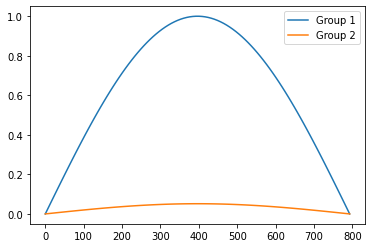

In [157]:
def get_k(beta2):
    k = (cnusf[0]*(cD[1]*beta2+csr[1])+cnusf[1]*css[1])/(cD[0]*beta2+csr[0])/(cD[1]*beta2+csr[1])
    return k

a = 793
beta = np.pi/a
beta2 = beta**2

k = get_k(beta2)
print(k)

D = np.array([[cD[0], 0],[0, cD[1]]])
Ei = np.array([[cnusf[0]/k-csr[0], cnusf[1]/k],[css[1], -csr[1]]])
Ec = la.inv(D) @ Ei
beta2, mu2 = la.eig(Ec)[0]

mu2 *= -1
s1 = la.eig(Ec)[1][1, 0]/la.eig(Ec)[1][0, 0]
s2 = la.eig(Ec)[1][1, 1]/la.eig(Ec)[1][0, 1]

x = np.linspace(0, a, num=100)
A = 1
phi1 = A * np.sin(beta*x)
phi2 = s1 * A * np.sin(beta*x)

print(max(flux2)/max(flux1))

plt.plot(x, phi1, label='Group 1')
plt.plot(x, phi2, label='Group 2')
plt.legend(loc='upper right')
plt.show()

## Solve using Finite Differences

i =  803
k =  1.0769928787336012
0.05156845259163281


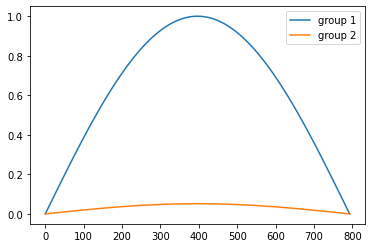

In [162]:
# Build system
N = 100
x = np.linspace(0, 793, num=N)
hx = x[1]-x[0]
hx2 = hx**2

# Diffusion matrix
DM1 = diags([1, -2, 1], [-1, 0, 1], shape=(N, N)).toarray()
DM2 = diags([1, -2, 1], [-1, 0, 1], shape=(N, N)).toarray()
D = np.zeros((2*N,2*N))
D[:N,:N] = cD[0]/hx2 * DM1
D[N:2*N,N:2*N] = cD[1]/hx2 * DM2

# Removal
SR = np.eye(2*N)
SR[:N,:N] = -csr[0] * SR[:N,:N]
SR[N:2*N,N:2*N] = -csr[1] * SR[N:2*N,N:2*N]

# In-scattering
aux1 = np.eye(N)
SS = np.zeros((2*N,2*N))
# No up-scattering for the moment
# SS[:N,N:2*N] = css[0] * aux1
SS[N:2*N,:N] = css[1] * aux1

# Fission
F = np.zeros((2*N,2*N))
F[:N,:N] = cnusf[0] * aux1
F[:N,N:2*N] =  cnusf[1] * aux1

# Apply BCs
LHS = D + SR + SS
LHS[0] = np.zeros(2*N)
LHS[0, 0] = 1.0
LHS[N-1] = np.zeros(2*N)
LHS[N-1, N-1] = 1.0
LHS[N] = np.zeros(2*N)
LHS[N, N] = 1.0
LHS[2*N-1] = np.zeros(2*N)
LHS[2*N-1, 2*N-1] = 1.0

F[0] = np.zeros(2*N)
F[N-1] = np.zeros(2*N)
F[N] = np.zeros(2*N)
F[2*N-1] = np.zeros(2*N)

k = 1.0
flux_old = np.ones(2*N)
RHS = -F @ flux_old

def converged(k_old, k):
    if abs((k - k_old)/k_old) <= 1e-10:
        return True
    else:
        return False

for i in range(1000):
    k_old = k
    flux_new = np.linalg.solve(LHS, RHS)
    kp = sum((F @ flux_new)[:N])/sum((F @ flux_old)[:N])
    k = k_old * kp
    RHS = -(1/k) * F @ flux_new
    flux_old = flux_new
    if converged(k_old, k) == True:
        break

print('i = ', i)
print('k = ', k)
        
flux1 = flux_old[:N]
M = max(flux1)
flux1 /= M
flux2 = flux_old[N:2*N]
flux2 /= M

print(max(flux2)/max(flux1))

plt.plot(x, flux1, label='group 1')
plt.plot(x, flux2, label='group 2')
plt.legend(loc='upper right')
plt.show()

## Adding upscattering

## Analytical

1.0876110110230892
0.051568452587309896


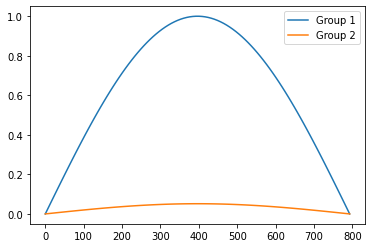

In [175]:
def get_k(beta2):
    k = (cnusf[0]*(cD[1]*beta2+csr[1])+cnusf[1]*css[1])/((cD[0]*beta2+csr[0])*(cD[1]*beta2+csr[1])-css[1]*css[0])
    return k

a = 793
beta = np.pi/a
beta2 = beta**2

k = get_k(beta2)
print(k)

D = np.array([[cD[0], 0],[0, cD[1]]])
Ei = np.array([[cnusf[0]/k-csr[0], cnusf[1]/k+css[0]],[css[1], -csr[1]]])
Ec = la.inv(D) @ Ei
beta2, mu2 = la.eig(Ec)[0]

mu2 *= -1
s1 = la.eig(Ec)[1][1, 0]/la.eig(Ec)[1][0, 0]
s2 = la.eig(Ec)[1][1, 1]/la.eig(Ec)[1][0, 1]

x = np.linspace(0, a, num=100)
A = 1
phi1 = A * np.sin(beta*x)
phi2 = s1 * A * np.sin(beta*x)

print(max(flux2)/max(flux1))

plt.plot(x, phi1, label='Group 1')
plt.plot(x, phi2, label='Group 2')
plt.legend(loc='upper right')
plt.show()

### Finite Differences

i =  797
k =  1.08761118515873
0.051568452587309896


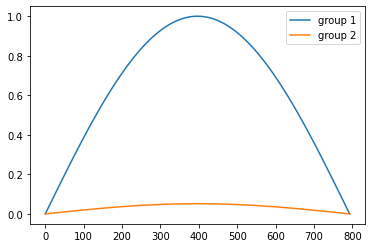

In [172]:
# Build system
N = 100
x = np.linspace(0, 793, num=N)
hx = x[1]-x[0]
hx2 = hx**2

# Diffusion matrix
DM1 = diags([1, -2, 1], [-1, 0, 1], shape=(N, N)).toarray()
DM2 = diags([1, -2, 1], [-1, 0, 1], shape=(N, N)).toarray()
D = np.zeros((2*N,2*N))
D[:N,:N] = cD[0]/hx2 * DM1
D[N:2*N,N:2*N] = cD[1]/hx2 * DM2

# Removal
SR = np.eye(2*N)
SR[:N,:N] = -csr[0] * SR[:N,:N]
SR[N:2*N,N:2*N] = -csr[1] * SR[N:2*N,N:2*N]

# In-scattering
aux1 = np.eye(N)
SS = np.zeros((2*N,2*N))
# No up-scattering for the moment
SS[:N,N:2*N] = css[0] * aux1
SS[N:2*N,:N] = css[1] * aux1

# Fission
F = np.zeros((2*N,2*N))
F[:N,:N] = cnusf[0] * aux1
F[:N,N:2*N] =  cnusf[1] * aux1

# Apply BCs
LHS = D + SR + SS
LHS[0] = np.zeros(2*N)
LHS[0, 0] = 1.0
LHS[N-1] = np.zeros(2*N)
LHS[N-1, N-1] = 1.0
LHS[N] = np.zeros(2*N)
LHS[N, N] = 1.0
LHS[2*N-1] = np.zeros(2*N)
LHS[2*N-1, 2*N-1] = 1.0

F[0] = np.zeros(2*N)
F[N-1] = np.zeros(2*N)
F[N] = np.zeros(2*N)
F[2*N-1] = np.zeros(2*N)

k = 1.0
flux_old = np.ones(2*N)
RHS = -F @ flux_old

def converged(k_old, k):
    if abs((k - k_old)/k_old) <= 1e-10:
        return True
    else:
        return False

for i in range(1000):
    k_old = k
    flux_new = np.linalg.solve(LHS, RHS)
    kp = sum((F @ flux_new)[:N])/sum((F @ flux_old)[:N])
    k = k_old * kp
    RHS = -(1/k) * F @ flux_new
    flux_old = flux_new
    if converged(k_old, k) == True:
        break

print('i = ', i)
print('k = ', k)
        
flux1 = flux_old[:N]
M = max(flux1)
flux1 /= M
flux2 = flux_old[N:2*N]
flux2 /= M

print(max(flux2)/max(flux1))

plt.plot(x, flux1, label='group 1')
plt.plot(x, flux2, label='group 2')
plt.legend(loc='upper right')
plt.show()

### Moltres

yt : [WARNING  ] 2020-06-16 09:42:17,732 No info_records found
yt : [WARNING  ] 2020-06-16 09:42:17,734 name_elem_var not found
yt : [INFO     ] 2020-06-16 09:42:17,738 Loading coordinates
yt : [INFO     ] 2020-06-16 09:42:17,740 Loading connectivity
yt : [INFO     ] 2020-06-16 09:42:17,774 Parameters: current_time              = 0.01
yt : [INFO     ] 2020-06-16 09:42:17,775 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2020-06-16 09:42:17,776 Parameters: domain_left_edge          = [ -0.127 -79.3     0.   ]
yt : [INFO     ] 2020-06-16 09:42:17,777 Parameters: domain_right_edge         = [  1.397 872.3     1.   ]
yt : [INFO     ] 2020-06-16 09:42:17,778 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2020-06-16 09:42:17,779 Loading coordinates
yt : [INFO     ] 2020-06-16 09:42:17,781 Loading connectivity
yt : [WARNING  ] 2020-06-16 09:42:17,786 name_elem_var not found



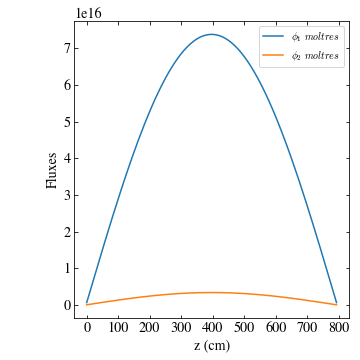

In [4]:
# Solves transient problem
file = '/home/roberto/projects/moltres/problems/mhtgr350/' + '2D-fuel-action'
plotter(file, [0, 0, 0], [0, 793, 0])

# 2 Groups, 3 Regions

a = 160

b = 160+793

c = 160+793+120

* Equations:

$\chi_1 = 1, \chi_2 = 0$, No upscattering.

Bottom reflector (B): $\Phi^B_i$

$0 = D_1 \frac{d^2}{dx^2}\Phi_1 - \Sigma^r_1 \Phi_1, x \in [0, a]$

$0 = D_2 \frac{d^2}{dx^2}\Phi_2 - \Sigma^r_2 \Phi_2 + \Sigma^s_{1-2} \Phi_1, x \in [0, a]$

Core (C): $\Phi^C_i$

$0 = D_1 \frac{d^2}{dx^2}\Phi_1 - \Sigma^r_1 \Phi_1 + (\nu \Sigma^f_1 \Phi_1 + \nu \Sigma^f_2 \Phi_2), x \in [a, b]$

$0 = D_2 \frac{d^2}{dx^2}\Phi_2 - \Sigma^r_2 \Phi_2 + \Sigma^s_{1-2} \Phi_1, x \in [a, b]$

Top reflector (T):  $\Phi^T_i$

$0 = D_1 \frac{d^2}{dx^2}\Phi_1 - \Sigma^r_1 \Phi_1, x \in [b, c]$

$0 = D_2 \frac{d^2}{dx^2}\Phi_2 - \Sigma^r_2 \Phi_2 + \Sigma^s_{1-2} \Phi_1, x \in [b, c]$

* BCs:

$\Phi_i^B (0) = 0$

$\Phi_i^B (a) = \Phi_i^C (a)$

$D^B_i\frac{d}{dx}\Phi_i^B (a) = D^C_i\frac{d}{dx}\Phi_i^C (a)$

$\Phi_i^C (b) = \Phi_i^T (b)$

$D^C_i\frac{d}{dx}\Phi_i^C (b) = D^T_i\frac{d}{dx}\Phi_i^T (b)$

$\Phi_i^T (c) = 0$

In [ ]:
base = '1/xs800000-500-100/htgr_2g_'
cD, csr, css, cchi, cnusf = get_xs(base + 'fuel_')
rD, rsr, rss, rchi, rnusf = get_xs(base + 'moderator_')

## Solve analytically

* Eigenvalues:

Bottom reflector: eigenvalues $-\mu_B^2 \& -\nu_B^2$, eigenvectors: $(1,S_1)$ and $(0,1)$

Core: eigenvalues $\beta_C^2 \& -\mu_C^2$, eigenvectors: $(1,S_2)$ and $(1,S_3)$

Core reflector: eigenvalues $-\mu_T^2 \& -\nu_T^2$, eigenvectors: $(1,S_3)$ and $(0,1)$

* Fluxes:

Bottom:

$\Phi^B_1 (x)= A sinh(\mu_B x) + B sinh(\mu_B x)$

$\Phi^B_2 (x)= S_1 A sinh(\mu_B x) + S_1 B sinh(\mu_B x) + C sinh(\nu_B x) + D sinh(\nu_B x)$

Core:

$\Phi^C_1 (x)= E sin(\beta_C x) + F cos(\beta_C x) + G sinh(\mu_C x) + H cosh(\mu_C x)$

$\Phi^C_2 (x)= S_2 E sin(\beta_C x) + S_2 F cos(\beta_C x) + S_3 G sinh(\mu_C x) + S_3 H cosh(\mu_C x)$

Top:

$\Phi^T_1 (x)= I sinh(\mu_T (c-x)) + J sinh(\mu_T (c-x))$

$\Phi^T_2 (x)= S_4 I sinh(\mu_T (c-x)) + S_4 J sinh(\mu_T (c-x)) + K sinh(\nu_T (c-x)) + L sinh(\nu_T (c-x))$

* BCs:

1), 2) $\Phi^B_i(0) = 0$

3), 4) $\Phi^B_i(a) = \Phi^C_i(a)$

5), 6) $D^B_i\frac{d}{dx}\Phi^B_i(a) = D^C_i\frac{d}{dx}\Phi^C_i(a)$

7), 8) $\Phi^C_i(b) = \Phi^T_i(b)$

9), 10) $D^C_i\frac{d}{dx}\Phi^C_i(b) = D^T_i\frac{d}{dx}\Phi^T_i(b)$

11), 12) $\Phi^T_i(c) = 0$

* Apply BCs:
1) B = 0

2) D = 0

$\Phi^B_1 (x)= A sinh(\mu_B x)$

$\Phi^B_2 (x)= S_1 A sinh(\mu_B x) + C sinh(\nu_B x)$

11) J = 0

12) L = 0

$\Phi^T_1 (x)= I sinh(\mu_T (c-x))$

$\Phi^T_2 (x)= S_4 I sinh(\mu_T (c-x)) + K sinh(\nu_T (c-x))$

3)

$E sin(\beta_C a) + F cos(\beta_C a) + G sinh(\mu_C a) + H cosh(\mu_C a) = A sinh(\mu_B a)$

4)

$S_2 E sin(\beta_C a) + S_2 F cos(\beta_C a) + S_3 G sinh(\mu_C a) + S_3 H cosh(\mu_C a) = S_1 A sinh(\mu_B a) + C sinh(\nu_B a)$

5)

$E \beta_C cos(\beta_C a) - F \beta_C sin(\beta_C a) + G \mu_C cosh(\mu_C a) + H \mu_C sinh(\mu_C a) = \frac{D^B_1}{D^C_1} A \mu_B cosh(\mu_B b)$

6)

$S_2 E \beta_C cos(\beta_C a) - S_2 F \beta_C sin(\beta_C a) + S_3 G \mu_C cosh(\mu_C a) + S_3 H \mu_C sinh(\mu_C a) = \frac{D^B_1}{D^C_1} (S_1 A \mu_B cosh(\mu_B a) + C \nu_B cosh(\mu_B a))  $

7)

$E sin(\beta_C b) + F cos(\beta_C b) + G sinh(\mu_C b) + H cosh(\mu_C b) = I sinh(\mu_T (c-b))$

8)

$S_2 E sin(\beta_C b) + S_2 F cos(\beta_C b) + S_3 G sinh(\mu_C b) + S_3 H cosh(\mu_C b) = S_4 I sinh(\mu_T (c-b)) + K sinh(\nu_T (c-b))$

9) and 10) are analogous to 5) and 6), I got lazy...

Build matrix M, and then compute det(M), when det(M) the system is critical.

In [221]:
def iter_k(k):
    D = np.array([[rD[0], 0],[0, rD[1]]])
    Ei = np.array([[-rsr[0], 0],[rss[1], -rsr[1]]])
    Eb = la.inv(D) @ Ei
    nub2, mub2 = -la.eig(Eb)[0]
    nub = np.sqrt(nub2)
    mub = np.sqrt(mub2)
    s1 = la.eig(Eb)[1][1, 1]/la.eig(Eb)[1][0, 1]

    nut = nub
    mut = mub
    s4 = s1

    D = np.array([[cD[0], 0],[0, cD[1]]])
    Ei = np.array([[cnusf[0]/k-csr[0], cnusf[1]/k],[css[1], -csr[1]]])
    Ec = la.inv(D) @ Ei
    betac2, muc2 = la.eig(Ec)[0]
    muc2 *= -1
    betac = np.sqrt(betac2)
    muc = np.sqrt(muc2)
    s2 = la.eig(Ec)[1][1, 0]/la.eig(Ec)[1][0, 0]
    s3 = la.eig(Ec)[1][1, 1]/la.eig(Ec)[1][0, 1]

    a = 160
    b = a+793
    c = b+120

    a /= c
    b /= c
    c /= c

    M = np.zeros((8, 8))

    shmuba = np.sinh(mub*a)
    chmuba = np.cosh(mub*a)
    M[0, 0] = -shmuba
    M[1, 0] = -s1 * shmuba
    M[2, 0] = -rD[0]/cD[0] * mub * chmuba
    M[3, 0] = -s1 * rD[1]/cD[1] * mub * chmuba

    shnuba = np.sinh(nub*a)
    chnuba = np.cosh(nub*a)
    M[0, 1] = 0
    M[1, 1] = -shnuba
    M[2, 1] = 0
    M[3, 1] = -rD[1]/cD[1] * nub * chnuba

    sbetaca = np.sin(betac*a)
    cbetaca = np.cos(betac*a)
    M[0, 2] = sbetaca
    M[1, 2] = s2 * sbetaca
    M[2, 2] = betac * cbetaca
    M[3, 2] = s2 * betac * cbetaca

    M[0, 3] = cbetaca
    M[1, 3] = s2 * cbetaca
    M[2, 3] = -betac * sbetaca
    M[3, 3] = -s2 * betac * sbetaca

    shmuca = np.sinh(muc*a)
    chmuca = np.cosh(muc*a)
    M[0, 4] = shmuca
    M[1, 4] = s3 * shmuca
    M[2, 4] = muc * chmuca
    M[3, 4] = s3 * muc * chmuca

    M[0, 5] = chmuca
    M[1, 5] = s3 * chmuca
    M[2, 5] = muc * chmuca
    M[3, 5] = s3 * muc * chmuca

    sbetacb = np.sin(betac*b)
    cbetacb = np.cos(betac*b)
    M[4, 2] = sbetacb
    M[5, 2] = s2 * sbetacb
    M[6, 2] = betac * cbetacb
    M[7, 2] = s2 * betac * cbetacb

    M[4, 3] = cbetacb
    M[5, 3] = s2 * cbetacb
    M[6, 3] = -betac * sbetacb
    M[7, 3] = -s2 * betac * sbetacb

    shmucb = np.sinh(muc*b)
    chmucb = np.cosh(muc*b)
    M[4, 4] = shmucb
    M[5, 4] = s3 * shmucb
    M[6, 4] = muc * chmucb
    M[7, 4] = s3 * muc * chmucb

    M[4, 5] = chmucb
    M[5, 5] = s3 * chmucb
    M[6, 5] = muc * chmucb
    M[7, 5] = s3 * muc * chmucb

    shmutb = np.sinh(mut*(c-b))
    chmutb = np.cosh(mut*(c-b))
    M[4, 6] = -shmutb
    M[5, 6] = -s4 * shmutb
    M[6, 6] = rD[0]/cD[0] * mut * chmutb
    M[7, 6] = s4 * rD[1]/cD[1] * mut * chmutb

    shnutb = np.sinh(nut*(c-b))
    chnutb = np.cosh(nut*(c-b))
    M[4, 7] = 0
    M[5, 7] = -shnutb
    M[6, 7] = 0
    M[7, 7] = rD[1]/cD[1] * nut * chnutb

    # print(M)
    # print(la.cond(M))
    # M[M < 1e-12] = 0
    # print(la.det(M))
    return la.det(M)

In [286]:
k = 1.079109122032088
print(iter_k(k))

0.0


In [287]:
D = np.array([[cD[0], 0],[0, cD[1]]])
Ei = np.array([[cnusf[0]/k-csr[0], cnusf[1]/k],[css[1], -csr[1]]])
Ec = la.inv(D) @ Ei
betac2, muc2 = la.eig(Ec)[0]
muc2 *= -1
betac = np.sqrt(betac2)
muc = np.sqrt(muc2)
s2 = la.eig(Ec)[1][1, 0]/la.eig(Ec)[1][0, 0]
s3 = la.eig(Ec)[1][1, 1]/la.eig(Ec)[1][0, 1]

The only thing missing to complete the analytical analysis is getting C,E,F,G,H,I,K = f(A)

finite differences gives k = 1.0770095257899428, one of the methods has something wrong, but they are close.

## Finite Differences

i =  1403
k =  1.0770095257899428


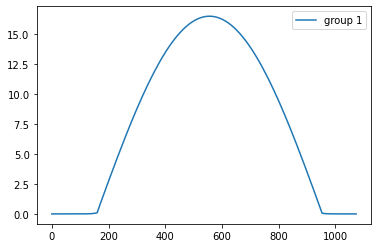

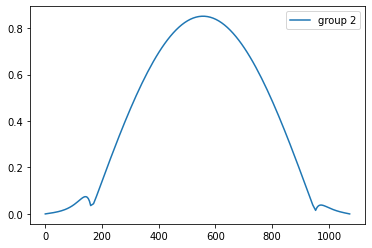

In [289]:
# Build system
Nb = 40
xb = np.linspace(0, 160, num=Nb)
hb = xb[1]-xb[0]
hb2 = hb**2

Nc = 80
xc = np.linspace(0, 793, num=Nc)
hc = xc[1]-xc[0]
Nc -= 2
xc = np.linspace(xb[-1]+hc, xb[-1]+793-hc, num=Nc)
hc = xc[1]-xc[0]
hc2 = hc**2

Nt = 40
xt = np.linspace(xc[-1]+hc, xc[-1]+hc+120, num=Nt)
ht = xt[1]-xt[0]
ht2 = ht**2

N = Nb+Nc+Nt
x = np.concatenate([xb, xc, xt])

# Diffusion matrix
DM = diags([1, -2, 1], [-1, 0, 1], shape=(N, N)).toarray()
D = np.zeros((2*N, 2*N))

D[:Nb,:Nb] = rD[0]/hb2 * DM[:Nb,:Nb]
D[Nb-1,Nb] = rD[0]/hc2

D[Nb:Nb+Nc,Nb-1:Nb+Nc+1] = cD[0]/hc2 * DM[Nb:Nb+Nc,Nb-1:Nb+Nc+1]

D[Nb+Nc,Nb+Nc-1] = rD[0]/hc2
D[Nb+Nc:Nb+Nc+Nt,Nb+Nc:Nb+Nc+Nt] = rD[0]/ht2 * DM[Nb+Nc:Nb+Nc+Nt,Nb+Nc:Nb+Nc+Nt]


D[N:N+Nb,N:N+Nb+1] = rD[1]/hb2 * DM[:Nb,:Nb+1]
D[N+Nb-1,N+Nb] = rD[1]/hc2

D[N+Nb:N+Nb+Nc,N+Nb-1:N+Nb+Nc+1] = cD[1]/hc2 * DM[Nb:Nb+Nc,Nb-1:Nb+Nc+1]

D[N+Nb+Nc,N+Nb+Nc-1] = rD[1]/hc2
D[N+Nb+Nc:N+Nb+Nc+Nt,N+Nb+Nc:N+Nb+Nc+Nt] = rD[1]/ht2 * DM[Nb+Nc:Nb+Nc+Nt,Nb+Nc:Nb+Nc+Nt]

# Removal
SR = np.eye(2*N)
SR[:Nb,:Nb] *= -rsr[0]
SR[Nb:Nb+Nc,Nb:Nb+Nc] *= -csr[0]
SR[Nb+Nc:Nb+Nc+Nt,Nb+Nc:Nb+Nc+Nt] *= -rsr[0]
SR[N:N+Nb,N:N+Nb] *= -rsr[1]
SR[N+Nb:N+Nb+Nc,N+Nb:N+Nb+Nc] *= -csr[1]
SR[N+Nb+Nc:N+Nb+Nc+Nt,N+Nb+Nc:N+Nb+Nc+Nt] *= -rsr[1]

# In-scattering
aux1 = np.eye(N)
SS = np.zeros((2*N, 2*N))
#SS[:Nb,N:N+Nb] = rss[0] * aux1[:Nb,:Nb]
#SS[Nb:Nb+Nc,N+Nb:N+Nb+Nc] = css[0] * aux1[Nb:Nb+Nc,Nb:Nb+Nc]
#SS[Nb+Nc:Nb+Nc+Nt,N+Nb+Nc:N+Nb+Nc+Nt] = rss[0] * aux1[Nb+Nc:Nb+Nc+Nt,Nb+Nc:Nb+Nc+Nt]
SS[N:N+Nb,:Nb] = rss[1] * aux1[:Nb,:Nb]
SS[N+Nb:N+Nb+Nc,Nb:Nb+Nc] = css[1] * aux1[Nb:Nb+Nc,Nb:Nb+Nc]
SS[N+Nb+Nc:N+Nb+Nc+Nt,Nb+Nc:Nb+Nc+Nt] = rss[1] * aux1[Nb+Nc:Nb+Nc+Nt,Nb+Nc:Nb+Nc+Nt]

# Fission
F = np.zeros((2*N, 2*N))
F[Nb:Nb+Nc,Nb:Nb+Nc] = cnusf[0] * aux1[Nb:Nb+Nc,Nb:Nb+Nc]
F[Nb:Nb+Nc,N+Nb:N+Nb+Nc] = cnusf[1] * aux1[Nb:Nb+Nc,Nb:Nb+Nc]

# Apply BCs
LHS = D + SR + SS
LHS[0] = np.zeros(2*N)
LHS[0, 0] = 1.0
LHS[N-1] = np.zeros(2*N)
LHS[N-1, N-1] = 1.0
LHS[N] = np.zeros(2*N)
LHS[N, N] = 1.0
LHS[2*N-1] = np.zeros(2*N)
LHS[2*N-1, 2*N-1] = 1.0

F[0] = np.zeros(2*N)
F[N-1] = np.zeros(2*N)
F[N] = np.zeros(2*N)
F[2*N-1] = np.zeros(2*N)

k = 1.0
flux_old = np.ones(2*N)
RHS = -F @ flux_old

def converged(k_old, k):
    if abs((k - k_old)/k_old) <= 1e-14:
        return True
    else:
        return False

for i in range(2000):
    k_old = k
    flux_new = np.linalg.solve(LHS, RHS)
    # k = k_old * sum(F @ flux_new)/sum(F @ flux_old)
    kp = sum((F @ flux_new)[:N])/sum((F @ flux_old)[:N])
    k = k_old * kp
    #print(k)
    RHS = -(1./k) * F @ flux_new
    flux_old = flux_new
    if converged(k_old, k) == True:
        break

print('i = ', i)
print('k = ', k)
#flux = flux_old/(sum(flux_old)*hx)
flux = flux_old
flux1 = flux[:N]
flux2 = flux[N:2*N]

plt.figure(1)
plt.plot(x, flux1, label='group 1')
plt.legend(loc='upper right')
plt.show()

plt.figure(2)
plt.plot(x, flux2, label='group 2')
plt.legend(loc='upper right')
plt.show()

## Adds upscattering

a = 160

b = 160+793

c = 160+793+120

* Equations:
    
Bottom reflector (B): $\Phi^B_i$

$0 = D_1 \frac{d^2}{dx^2}\Phi_1 - \Sigma^r_1 \Phi_1 + \Sigma^s_{2-1} \Phi_2, x \in [0, a]$

$0 = D_2 \frac{d^2}{dx^2}\Phi_2 - \Sigma^r_2 \Phi_2 + \Sigma^s_{1-2} \Phi_1, x \in [0, a]$

Core (C): $\Phi^C_i$

$0 = D_1 \frac{d^2}{dx^2}\Phi_1 - \Sigma^r_1 \Phi_1 + \Sigma^s_{2-1} \Phi_2 + \chi_1(\nu \Sigma^f_1 \Phi_1 + \nu \Sigma^f_2 \Phi_2), x \in [a, b]$

$0 = D_2 \frac{d^2}{dx^2}\Phi_2 - \Sigma^r_2 \Phi_2 + \Sigma^s_{1-2} \Phi_1 + \chi_2(\nu \Sigma^f_1 \Phi_1 + \nu \Sigma^f_2 \Phi_2), x \in [a, b]$

Top reflector (T):  $\Phi^T_i$

$0 = D_1 \frac{d^2}{dx^2}\Phi_1 - \Sigma^r_1 \Phi_1 + \Sigma^s_{2-1} \Phi_2, x \in [b, c]$

$0 = D_2 \frac{d^2}{dx^2}\Phi_2 - \Sigma^r_2 \Phi_2 + \Sigma^s_{1-2} \Phi_1, x \in [b, c]$

* BCs:

$\Phi_i^B (0) = 0$

$\Phi_i^B (a) = \Phi_i^C (a)$

$D^B_i\frac{d}{dx}\Phi_i^B (a) = D^C_i\frac{d}{dx}\Phi_i^C (a)$

$\Phi_i^C (b) = \Phi_i^T (b)$

$D^C_i\frac{d}{dx}\Phi_i^C (b) = D^T_i\frac{d}{dx}\Phi_i^T (b)$

$\Phi_i^T (c) = 0$

In [11]:
base = '1/xs800000-500-100/htgr_2g_'
cD, csr, css, cchi, cnusf = get_xs(base + 'fuel_')
rD, rsr, rss, rchi, rnusf = get_xs(base + 'moderator_')

i =  359
k =  1.0876219489212817


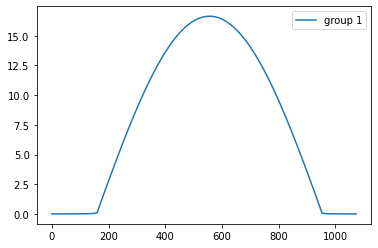

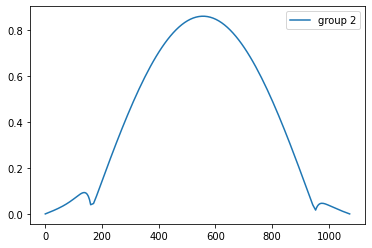

In [12]:
# Build system
Nb = 40
xb = np.linspace(0, 160, num=Nb)
hb = xb[1]-xb[0]
hb2 = hb**2

Nc = 80
xc = np.linspace(0, 793, num=Nc)
hc = xc[1]-xc[0]
Nc -= 2
xc = np.linspace(xb[-1]+hc, xb[-1]+793-hc, num=Nc)
hc = xc[1]-xc[0]
hc2 = hc**2

Nt = 40
xt = np.linspace(xc[-1]+hc, xc[-1]+hc+120, num=Nt)
ht = xt[1]-xt[0]
ht2 = ht**2

N = Nb+Nc+Nt
x = np.concatenate([xb, xc, xt])

# Diffusion matrix
DM = diags([1, -2, 1], [-1, 0, 1], shape=(N, N)).toarray()
D = np.zeros((2*N, 2*N))

D[:Nb,:Nb] = rD[0]/hb2 * DM[:Nb,:Nb]
D[Nb-1,Nb] = rD[0]/hc2

D[Nb:Nb+Nc,Nb-1:Nb+Nc+1] = cD[0]/hc2 * DM[Nb:Nb+Nc,Nb-1:Nb+Nc+1]

D[Nb+Nc,Nb+Nc-1] = rD[0]/hc2
D[Nb+Nc:Nb+Nc+Nt,Nb+Nc:Nb+Nc+Nt] = rD[0]/ht2 * DM[Nb+Nc:Nb+Nc+Nt,Nb+Nc:Nb+Nc+Nt]


D[N:N+Nb,N:N+Nb+1] = rD[1]/hb2 * DM[:Nb,:Nb+1]
D[N+Nb-1,N+Nb] = rD[1]/hc2

D[N+Nb:N+Nb+Nc,N+Nb-1:N+Nb+Nc+1] = cD[1]/hc2 * DM[Nb:Nb+Nc,Nb-1:Nb+Nc+1]

D[N+Nb+Nc,N+Nb+Nc-1] = rD[1]/hc2
D[N+Nb+Nc:N+Nb+Nc+Nt,N+Nb+Nc:N+Nb+Nc+Nt] = rD[1]/ht2 * DM[Nb+Nc:Nb+Nc+Nt,Nb+Nc:Nb+Nc+Nt]

# Removal
SR = np.eye(2*N)
SR[:Nb,:Nb] *= -rsr[0]
SR[Nb:Nb+Nc,Nb:Nb+Nc] *= -csr[0]
SR[Nb+Nc:Nb+Nc+Nt,Nb+Nc:Nb+Nc+Nt] *= -rsr[0]
SR[N:N+Nb,N:N+Nb] *= -rsr[1]
SR[N+Nb:N+Nb+Nc,N+Nb:N+Nb+Nc] *= -csr[1]
SR[N+Nb+Nc:N+Nb+Nc+Nt,N+Nb+Nc:N+Nb+Nc+Nt] *= -rsr[1]

# In-scattering
aux1 = np.eye(N)
SS = np.zeros((2*N, 2*N))
SS[:Nb,N:N+Nb] = rss[0] * aux1[:Nb,:Nb]
SS[Nb:Nb+Nc,N+Nb:N+Nb+Nc] = css[0] * aux1[Nb:Nb+Nc,Nb:Nb+Nc]
SS[Nb+Nc:Nb+Nc+Nt,N+Nb+Nc:N+Nb+Nc+Nt] = rss[0] * aux1[Nb+Nc:Nb+Nc+Nt,Nb+Nc:Nb+Nc+Nt]
SS[N:N+Nb,:Nb] = rss[1] * aux1[:Nb,:Nb]
SS[N+Nb:N+Nb+Nc,Nb:Nb+Nc] = css[1] * aux1[Nb:Nb+Nc,Nb:Nb+Nc]
SS[N+Nb+Nc:N+Nb+Nc+Nt,Nb+Nc:Nb+Nc+Nt] = rss[1] * aux1[Nb+Nc:Nb+Nc+Nt,Nb+Nc:Nb+Nc+Nt]

# Fission
F = np.zeros((2*N, 2*N))
F[Nb:Nb+Nc,Nb:Nb+Nc] = cnusf[0] * aux1[Nb:Nb+Nc,Nb:Nb+Nc]
F[Nb:Nb+Nc,N+Nb:N+Nb+Nc] = cnusf[1] * aux1[Nb:Nb+Nc,Nb:Nb+Nc]

# Apply BCs
LHS = D + SR + SS
LHS[0] = np.zeros(2*N)
LHS[0, 0] = 1.0
LHS[N-1] = np.zeros(2*N)
LHS[N-1, N-1] = 1.0
LHS[N] = np.zeros(2*N)
LHS[N, N] = 1.0
LHS[2*N-1] = np.zeros(2*N)
LHS[2*N-1, 2*N-1] = 1.0

F[0] = np.zeros(2*N)
F[N-1] = np.zeros(2*N)
F[N] = np.zeros(2*N)
F[2*N-1] = np.zeros(2*N)

k = 1.0
flux_old = np.ones(2*N)
RHS = -F @ flux_old

def converged(k_old, k):
    if abs((k - k_old)/k_old) <= 1e-7:
        return True
    else:
        return False

for i in range(1000):
    k_old = k
    flux_new = np.linalg.solve(LHS, RHS)
    #k = k_old * sum(F @ flux_new)/sum(F @ flux_old)
    kp = sum(F @ flux_new)/sum(F @ flux_old)
    #kp = sum((F @ flux_new)[:N])/sum((F @ flux_old)[:N])
    k = k_old * kp
    #print(k)
    RHS = -(1./k) * F @ flux_new
    flux_old = flux_new
    if converged(k_old, k) == True:
        break

print('i = ', i)
print('k = ', k)
#flux = flux_old/(sum(flux_old)*hx)
flux = flux_old
flux1 = flux[:N]
flux2 = flux[N:2*N]

plt.figure(1)
plt.plot(x, flux1, label='group 1')
plt.legend(loc='upper right')
plt.show()

plt.figure(2)
plt.plot(x, flux2, label='group 2')
plt.legend(loc='upper right')
plt.show()

### Moltres

yt : [WARNING  ] 2020-06-16 09:43:13,631 No info_records found
yt : [WARNING  ] 2020-06-16 09:43:13,640 name_elem_var not found
yt : [INFO     ] 2020-06-16 09:43:13,649 Loading coordinates
yt : [INFO     ] 2020-06-16 09:43:13,657 Loading connectivity
yt : [INFO     ] 2020-06-16 09:43:13,685 Parameters: current_time              = 0.01
yt : [INFO     ] 2020-06-16 09:43:13,686 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2020-06-16 09:43:13,687 Parameters: domain_left_edge          = [  -0.127 -107.3      0.   ]
yt : [INFO     ] 2020-06-16 09:43:13,688 Parameters: domain_right_edge         = [1.3970e+00 1.1803e+03 1.0000e+00]
yt : [INFO     ] 2020-06-16 09:43:13,690 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2020-06-16 09:43:13,692 Loading coordinates
yt : [INFO     ] 2020-06-16 09:43:13,694 Loading connectivity
yt : [WARNING  ] 2020-06-16 09:43:13,703 name_elem_var not found



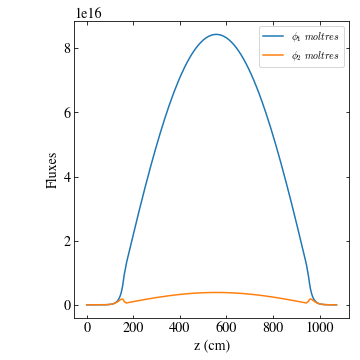

In [6]:
# Solves transient problem
file = '/home/roberto/projects/moltres/problems/mhtgr350/' + '2D-fuel-reflec-action'
plotter(file, [0, 0, 0], [0, 1073, 0])